In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 100

autoencoder_train_dataloader = torch.utils.data.DataLoader(
    tv.datasets.MNIST(root='../data/mnist', train=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])),
    batch_size=batch_size,
    shuffle=True)

autoencoder_test_dataloader = torch.utils.data.DataLoader(
    tv.datasets.MNIST(root='../data/mnist', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])),
    batch_size=batch_size,
    shuffle=True)

In [3]:
img_dims = 28

def round_bits(x, quantize_bits):
    mul = 2**quantize_bits
    x = x * mul
    x = torch.floor(x)
    x = x / mul
    return x

class Autoencoder(nn.Module):
    def __init__(self, encoding_dims):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_dims*img_dims, encoding_dims),
            nn.ReLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dims, img_dims*img_dims),
            nn.Unflatten(1, (1, img_dims, img_dims)),
            nn.Sigmoid(),
            )
    def forward(self, x, quantize_bits=None):
        x = self.encoder(x)
        x = torch.sigmoid(x)
        if quantize_bits is not None:
            x = round_bits(x, quantize_bits)
        x = torch.logit(x, eps=0.001)
        x = self.decoder(x)
        return x

In [27]:
results = []
for encoding_dims in [4, 8, 16, 32, 64, 128, 256]:
    # train
    print('Doing encoding_dims = {:d}'.format(encoding_dims))
    autoencoder = Autoencoder(encoding_dims=encoding_dims).to(device)
    distance = nn.BCELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    num_epochs = 50
    for epoch in range(num_epochs):
        for imgs, _ in autoencoder_train_dataloader:
            imgs = Variable(imgs).to(device)
            output = autoencoder(imgs)
            loss = distance(output, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del imgs
            del output
        print('epoch {:d}/{:d}, loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()), end='\r')
    # test
    del distance
    del optimizer
    distance = nn.MSELoss()
    for quantize_bits in [2, 4, 8, 16, 32]:
        loss = 0
        for imgs, _ in autoencoder_train_dataloader:
            imgs = Variable(imgs).to(device)
            with torch.no_grad():
                output = autoencoder(imgs, quantize_bits=quantize_bits)
            loss += distance(output, imgs)
            del imgs
            del output
        print('encoding_dims = {:d}, quantize_bits = {:d}, loss = {:.2f}'.format(encoding_dims, quantize_bits, loss))
        results.append((encoding_dims, quantize_bits, loss.item()))
    # free CUDA memory
    del autoencoder
    del distance
    torch.cuda.empty_cache()

Doing encoding_dims = 4
encoding_dims = 4, quantize_bits = 2, loss = 466.81
encoding_dims = 4, quantize_bits = 4, loss = 461.31
encoding_dims = 4, quantize_bits = 8, loss = 455.70
encoding_dims = 4, quantize_bits = 16, loss = 454.29
encoding_dims = 4, quantize_bits = 32, loss = 454.29
Doing encoding_dims = 8
encoding_dims = 8, quantize_bits = 2, loss = 461.97
encoding_dims = 8, quantize_bits = 4, loss = 449.11
encoding_dims = 8, quantize_bits = 8, loss = 435.66
encoding_dims = 8, quantize_bits = 16, loss = 433.88
encoding_dims = 8, quantize_bits = 32, loss = 433.88
Doing encoding_dims = 16
encoding_dims = 16, quantize_bits = 2, loss = 448.30
encoding_dims = 16, quantize_bits = 4, loss = 394.12
encoding_dims = 16, quantize_bits = 8, loss = 347.80
encoding_dims = 16, quantize_bits = 16, loss = 341.71
encoding_dims = 16, quantize_bits = 32, loss = 341.72
Doing encoding_dims = 32
encoding_dims = 32, quantize_bits = 2, loss = 463.18
encoding_dims = 32, quantize_bits = 4, loss = 395.22
encod

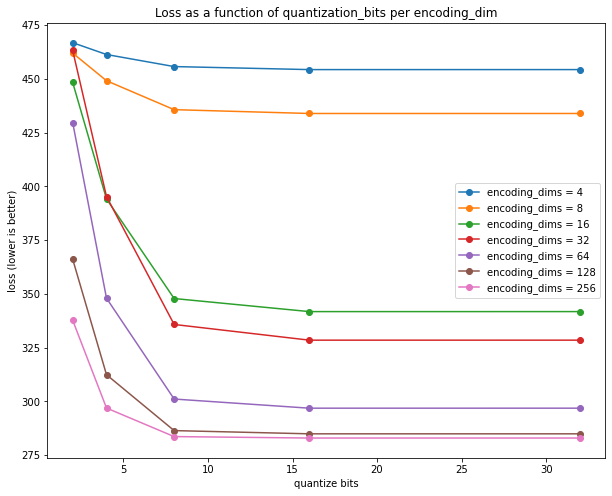

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
quantize_bits = sorted(list(set(map(lambda x: x[1], results))))
encoding_dims = sorted(list(set(map(lambda x: x[0], results))))
for encoding_dim in encoding_dims:
    y = list(map(lambda x: x[2], filter(lambda x: x[0] == encoding_dim, results)))
    plt.plot(quantize_bits, y, label = "encoding_dims = {:d}".format(encoding_dim), marker='o')
plt.xlabel('quantize bits')
plt.ylabel('loss (lower is better)')
plt.title('Loss as a function of quantization_bits per encoding_dim')
plt.legend()
plt.show()

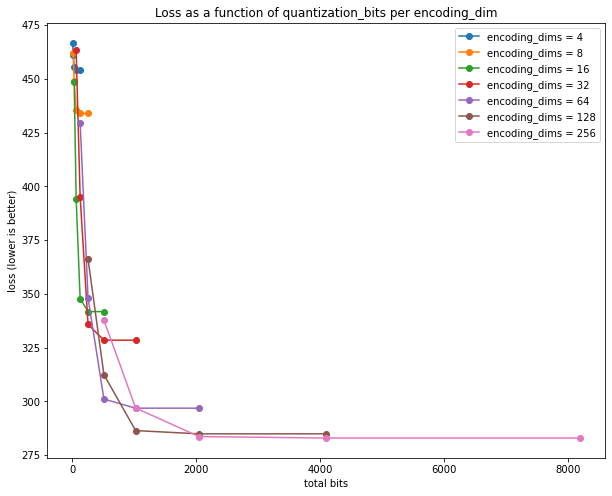

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
quantize_bits = sorted(list(set(map(lambda x: x[1], results))))
encoding_dims = sorted(list(set(map(lambda x: x[0], results))))
for encoding_dim in encoding_dims:
    x = list(map(lambda x: x[0]*x[1], filter(lambda x: x[0] == encoding_dim, results)))
    y = list(map(lambda x: x[2], filter(lambda x: x[0] == encoding_dim, results)))
    plt.plot(x, y, label = "encoding_dims = {:d}".format(encoding_dim), marker='o')
plt.xlabel('total bits')
plt.ylabel('loss (lower is better)')
plt.title('Loss as a function of quantization_bits per encoding_dim')
plt.legend()
plt.show()